# Exploratory Data Analysis

In [1]:
# import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\TEJAS\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# load the dataset
customers_df = pd.read_csv('../datasets/Customers.csv')
products_df = pd.read_csv('../datasets/Products.csv')
transactions_df = pd.read_csv('../datasets/Transactions.csv')

## 1. Data Overview and Descriptive Statistics

In [3]:
# customers dataset
customers_df.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [4]:
# products dataset
products_df.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [5]:
# transactions dataset
transactions_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 7:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [6]:
# customers dataset info
print('Shape of customers dataset:', customers_df.shape)

print('\nData-types of customers dataset:\n', customers_df.dtypes)

print('\nDiscriptive statistics of customers dataset:\n', customers_df.describe())

Shape of customers dataset: (200, 4)

Data-types of customers dataset:
 CustomerID      object
CustomerName    object
Region          object
SignupDate      object
dtype: object

Discriptive statistics of customers dataset:
        CustomerID      CustomerName         Region  SignupDate
count         200               200            200         200
unique        200               200              4         179
top         C0001  Lawrence Carroll  South America  2024-11-11
freq            1                 1             59           3


In [7]:
# products dataset info
print('Shape of products dataset:', products_df.shape)
print('\nData-types of products dataset:\n', products_df.dtypes)
print('\nDiscriptive statistics of products dataset:\n', products_df.describe())

Shape of products dataset: (100, 4)

Data-types of products dataset:
 ProductID       object
ProductName     object
Category        object
Price          float64
dtype: object

Discriptive statistics of products dataset:
             Price
count  100.000000
mean   267.551700
std    143.219383
min     16.080000
25%    147.767500
50%    292.875000
75%    397.090000
max    497.760000


In [8]:
# transactions dataset info
print('Shape of transactions dataset:', transactions_df.shape)
print('\nData-types of transactions dataset:\n', transactions_df.dtypes)
print('\nDiscriptive statistics of transactions dataset:\n', transactions_df.describe())

Shape of transactions dataset: (1000, 7)

Data-types of transactions dataset:
 TransactionID       object
CustomerID          object
ProductID           object
TransactionDate     object
Quantity             int64
TotalValue         float64
Price              float64
dtype: object

Discriptive statistics of transactions dataset:
           Quantity   TotalValue       Price
count  1000.000000  1000.000000  1000.00000
mean      2.537000   689.995560   272.55407
std       1.117981   493.144478   140.73639
min       1.000000    16.080000    16.08000
25%       2.000000   295.295000   147.95000
50%       3.000000   588.880000   299.93000
75%       4.000000  1011.660000   404.40000
max       4.000000  1991.040000   497.76000


## 2. Data Preprocessing

In [9]:
# Check for missing values
print("\nMissing values in Customers DataFrame:")  
print(customers_df.isnull().sum())  
print("\nMissing values in Products DataFrame:")  
print(products_df.isnull().sum())  
print("\nMissing values in Transactions DataFrame:")  
print(transactions_df.isnull().sum()) 


Missing values in Customers DataFrame:
CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

Missing values in Products DataFrame:
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64

Missing values in Transactions DataFrame:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


#### No missing values found

In [10]:
# Drop duplicates if any
customers_df.drop_duplicates(inplace=True)
products_df.drop_duplicates(inplace=True)
transactions_df.drop_duplicates(inplace=True)

In [11]:
# convert TransactionDate to datetime format
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
transactions_df['TransactionDate'].head()


0   2024-08-25 12:38:23
1   2024-05-27 22:23:54
2   2024-04-25 07:38:55
3   2024-03-26 22:55:37
4   2024-03-21 15:10:10
Name: TransactionDate, dtype: datetime64[ns]

## 3. EDA

### Trends over time

In [12]:
# 1. monthly transaction counts
monthly_transactions_count = transactions_df.resample('M', on='TransactionDate').size()
monthly_transactions_count

C:\Users\TEJAS\AppData\Local\Temp\ipykernel_4076\1880014757.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_transactions_count = transactions_df.resample('M', on='TransactionDate').size()


TransactionDate
2023-12-31      4
2024-01-31    107
2024-02-29     77
2024-03-31     80
2024-04-30     86
2024-05-31     86
2024-06-30     69
2024-07-31     96
2024-08-31     94
2024-09-30     96
2024-10-31     70
2024-11-30     57
2024-12-31     78
Freq: ME, dtype: int64

In [13]:
# convert index to months
monthly_transactions_count.index = monthly_transactions_count.index.strftime('%b %Y')

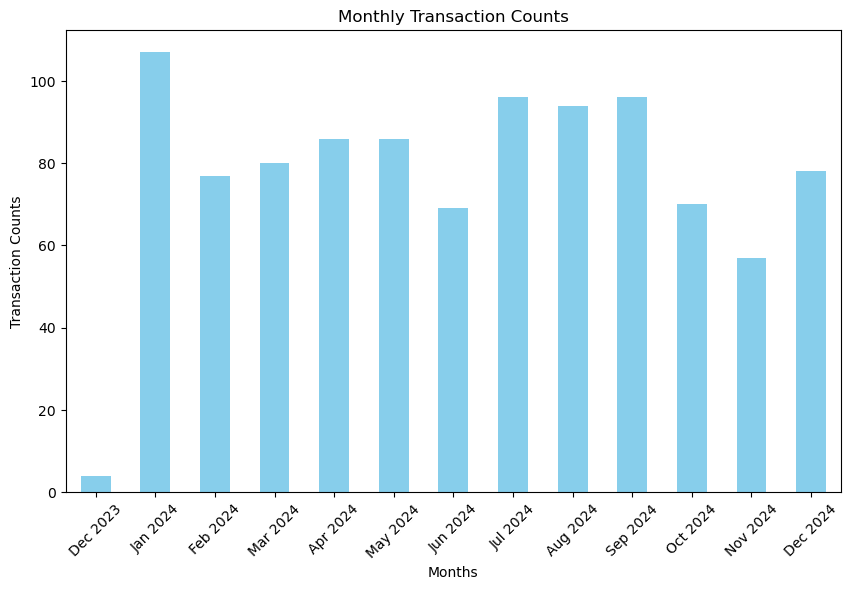

In [14]:
# plot bar graph of monthly transaction counts
plt.figure(figsize=(10, 6))
monthly_transactions_count.plot(kind='bar', color='skyblue')
plt.title('Monthly Transaction Counts')
plt.xlabel('Months')
plt.ylabel('Transaction Counts')
plt.xticks(rotation=45)
plt.show()

C:\Users\TEJAS\AppData\Local\Temp\ipykernel_4076\324867077.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_values = transactions_df.resample('M', on='TransactionDate')['TotalValue'].sum()


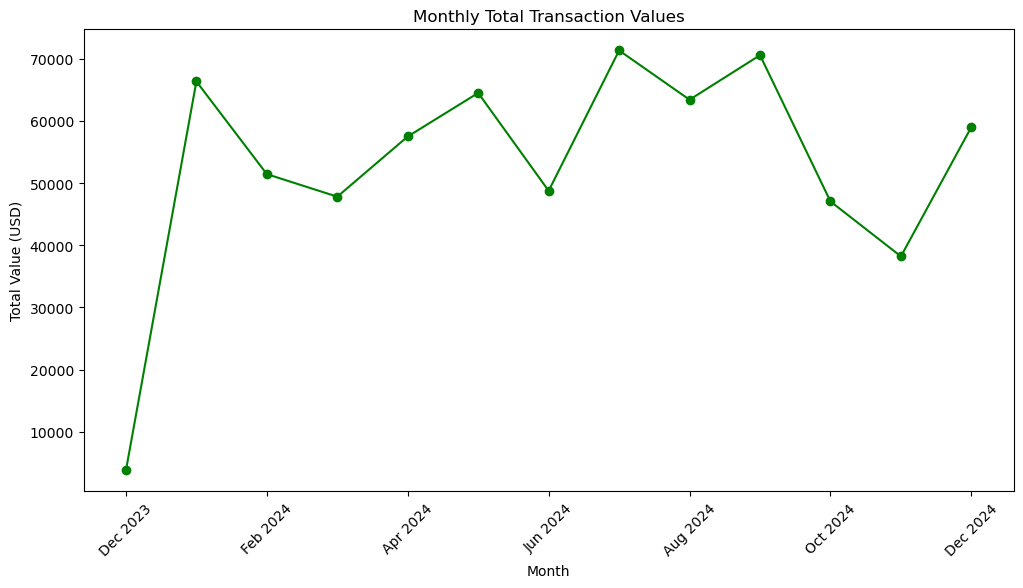

In [15]:
# 2. Monthly total transaction values
monthly_values = transactions_df.resample('M', on='TransactionDate')['TotalValue'].sum() 
monthly_values.index = monthly_values.index.strftime('%b %Y') 
plt.figure(figsize=(12, 6))  
monthly_values.plot(kind='line', marker='o', color='green')  
plt.title('Monthly Total Transaction Values')  
plt.xlabel('Month')  
plt.ylabel('Total Value (USD)')  
plt.xticks(rotation=45)  
plt.show()  

## Product Analysis

In [16]:
# 1. Top selling products
top_products = transactions_df.groupby('ProductID')['Quantity'].sum().nlargest(10).reset_index()  # Convert to DataFrame  
top_products = top_products.merge(products_df[['ProductID', 'ProductName']], on='ProductID', how='left')  

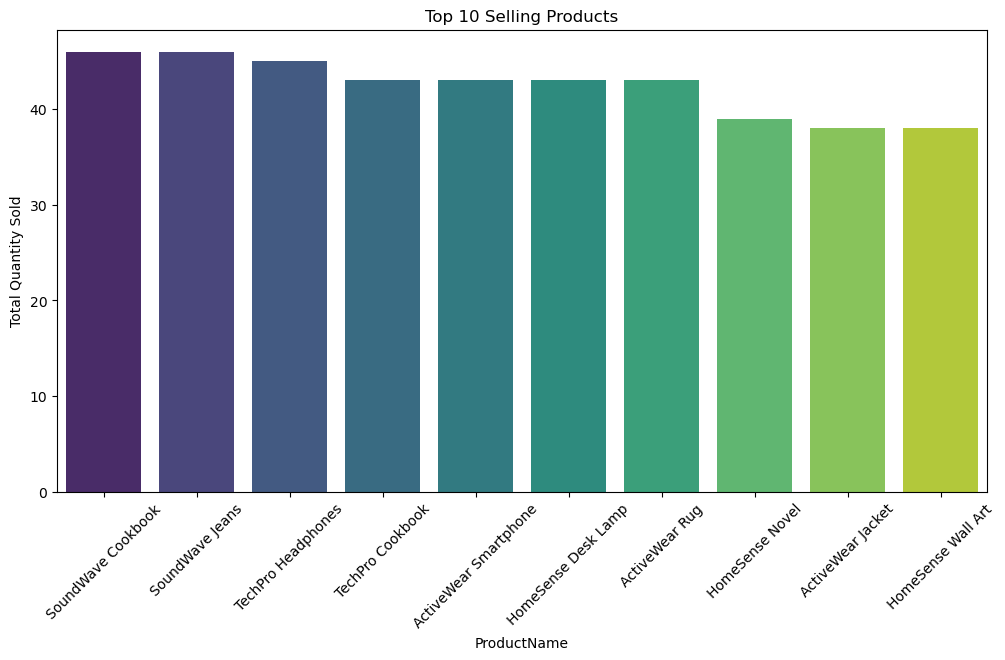

In [17]:
plt.figure(figsize=(12, 6))  
sns.barplot(data=top_products, x='ProductName', y='Quantity', palette='viridis')  
plt.title('Top 10 Selling Products')  
plt.xticks(rotation=45)  
plt.ylabel('Total Quantity Sold')  
plt.show()  

## Customer Engagement

In [18]:
# Merge customer and transactions data
customer_transactions = pd.merge(transactions_df, customers_df, on='CustomerID')
# customer_transactions.head()

customer_frequency = customer_transactions.groupby(['CustomerID', 'CustomerName']).size().reset_index(name='NumberOfTransactions') 
# customer_frequency.head()

customer_frequency = customer_frequency.sort_values(by='NumberOfTransactions', ascending=False)

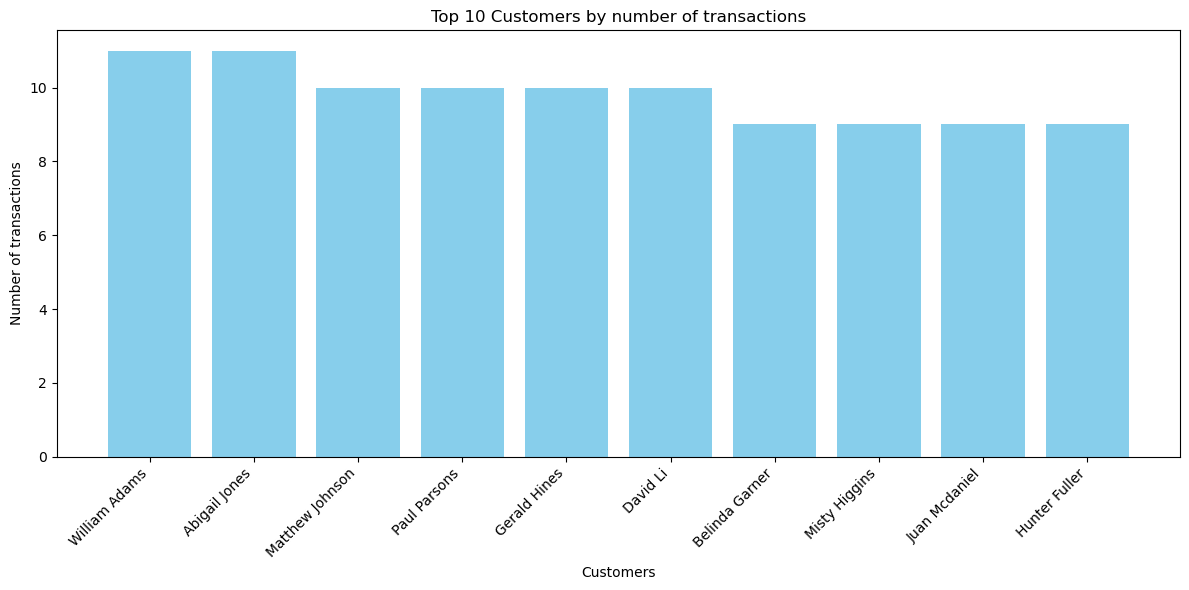

In [19]:
plt.figure(figsize=(12, 6))
plt.bar(customer_frequency['CustomerName'][:10], customer_frequency['NumberOfTransactions'][:10], color='skyblue')
plt.title('Top 10 Customers by number of transactions')
plt.xlabel('Customers')
plt.ylabel('Number of transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [20]:
print("\nTop 10 Customers by Transaction Frequency:")
customer_frequency.head(10)


Top 10 Customers by Transaction Frequency:


,CustomerID,CustomerName,NumberOfTransactions
155,C0156,William Adams,11
108,C0109,Abigail Jones,11
174,C0175,Matthew Johnson,10
140,C0141,Paul Parsons,10
64,C0065,Gerald Hines,10
7,C0008,David Li,10
83,C0084,Belinda Garner,9
74,C0075,Misty Higgins,9
164,C0165,Juan Mcdaniel,9
146,C0147,Hunter Fuller,9


In [21]:
# merge all three dataframes
df = transactions_df.merge(customers_df, on='CustomerID', how='left').merge(products_df, on='ProductID', how='left')
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [22]:
# drop unnecessary columns
df.drop(['Price_y'], axis=1, inplace=True)

In [23]:
# rename columns
df.rename(columns={'Price_x': 'Price'}, inplace=True)
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate,ProductName,Category
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics


In [26]:
# Save DataFrame to CSV  
df.to_csv('../datasets/merged_data.csv', index=False)  
print("DataFrame saved as 'merged_data.csv'")  

DataFrame saved as 'merged_data.csv'
